# 5 Modeling

## 5.1 Imports

In [71]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import tree, metrics

## 5.2 Load Model

In [38]:
expected_model_version = '1.0'
model_path = '../models/credit_card_fraud_detection_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

## 5.3 Load Data

In [62]:
df= pd.read_csv('../Data/step3_features.csv')
test_data= pd.read_csv('../Data/Test_data.csv')

In [40]:
df.head()

,account_number,merchant,trans_amount,first_name,last_name,street,city,state,zip,lat,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2703186189652095,"fraud_Rippin, Kub and Mann",4.97,Jennifer,Banks,561 Perry Cove,Moravian Falls,NC,28654,36.0788,...,0,0,0,1,0,0,0,0,0,0
1,630423337322,"fraud_Heller, Gutmann and Zieme",107.23,Stephanie,Gill,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,...,0,0,0,0,0,0,0,0,0,0
2,38859492057661,fraud_Lind-Buckridge,220.11,Edward,Sanchez,594 White Dale Suite 530,Malad City,ID,83252,42.1808,...,0,0,0,0,0,0,0,0,0,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",45.00,Jeremy,White,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,...,0,0,0,0,0,0,0,0,0,1
4,375534208663984,fraud_Keeling-Crist,41.96,Tyler,Garcia,408 Bradley Rest,Doe Hill,VA,24433,38.4207,...,0,0,0,0,1,0,0,0,0,1


## 5.4 Refit Model On All Available Data

In [41]:
X= df.loc[:, model.X_columns]
y= df.loc[:, 'is_fraud']

In [42]:
len(X), len(y)

(1296675, 1296675)

In [43]:
# Fit model 
model.fit(X, y)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, random_state=1234)

In [44]:
# Find recall score using cross validation

cv_results = cross_validate(model, X, y, scoring='recall', cv=5, n_jobs=-1)

In [45]:
cv_results['test_score']

array([0.91805463, 0.92405063, 0.89740173, 0.92671552, 0.93608522])

In [46]:
recall_mean, recall_std = np.mean(cv_results['test_score']), np.std(cv_results['test_score'])
recall_mean, recall_std

(0.9204615476056353, 0.012912329069625314)

In [76]:
#Use grid search to find the best estimator

param_grid = {'max_depth': np.arange(5, 10), 'criterion':['gini', 'entropy'], 'class_weight' : [None, 'balanced']}
grid_cv_results = GridSearchCV(model, param_grid,cv=5, scoring='recall')

In [77]:
grid_cv_results.fit(X, y)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy', max_depth=9,
                                              random_state=1234),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([5, 6, 7, 8, 9])},
             scoring='recall')

In [78]:
grid_cv_results.best_params_

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9}

In [79]:
print("Best Score:" + str(grid_cv_results.best_score_))
print("Best Parameters: " + str(grid_cv_results.best_params_))

Best Score:0.9213939929971231
Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9}


>After hyperparameter tuning, the results showed that the gini random forest with max_depth of 9 is our best model.

In [88]:
# Using cross validation to find the mean and std of the best score
rf_cv_best_results= cross_validate(grid_cv_results.best_estimator_, X, y, cv=5, scoring= 'recall')

In [96]:
rf_cv_scores=rf_cv_best_results['test_score']
mean_recall= np.mean(rf_cv_best_results['test_score'])
sd_recall= np.std(rf_cv_best_results['test_score'])
print('mean recall score is {:.2f} with std of {:.2f}.'.format(mean_recall, sd_recall))

mean recall score is 0.92 with std of 0.01.


In [80]:
y_pred = grid_cv_results.best_estimator_.predict(X) 
y_pred = pd.Series(y_pred)

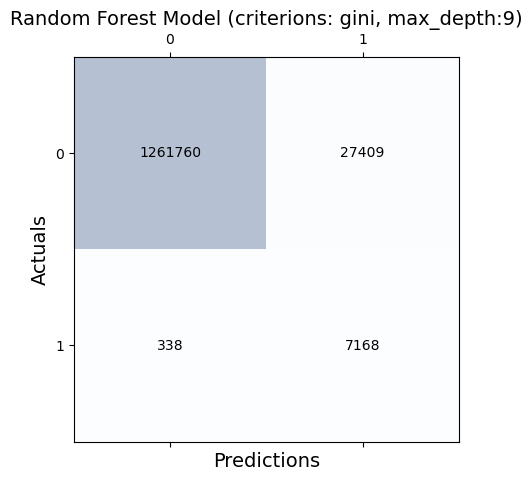

In [103]:
conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Random Forest Model (criterions: gini, max_depth:9)', fontsize=14)
plt.show()

## 5.5 Predict The Test Data Using The Best Model

In [82]:
# Use test data from train-test split in the training step to evaluate model performance 

X_test= test_data.drop(columns=['is_fraud'])
y_test= test_data['is_fraud']

In [83]:
X_test.shape, y_test.shape

((324169, 28), (324169,))

In [84]:
y_test_pred = grid_cv_results.best_estimator_.predict(X_test) 

In [85]:
# model evaluation 
print("Model: RandomForest Model Best Estimator")
print("Accuracy:", metrics.accuracy_score(y_test,y_test_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_test_pred))
print('Precision score:' , metrics.precision_score(y_test,y_test_pred))
print('Recall score:' , metrics.recall_score(y_test,y_test_pred))
print('F1 score:' , metrics.f1_score(y_test,y_test_pred))

Model: RandomForest Model Best Estimator
Accuracy: 0.9784711061205729
Balanced accuracy: 0.9642787349871331
Precision score: 0.20569912321181358
Recall score: 0.9499200852424081
F1 score: 0.3381697486960645


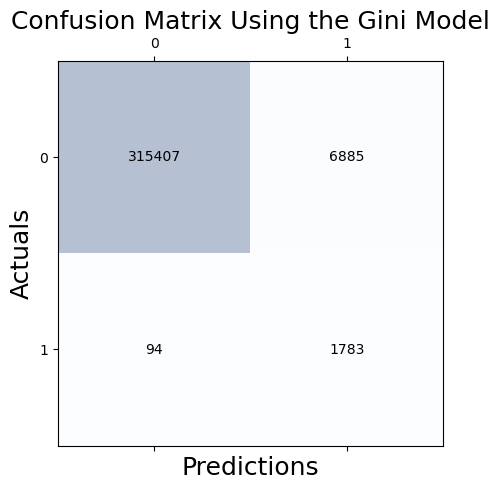

In [86]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix Using the Gini Model', fontsize=18)
plt.show()

>Therefore, our random forest model with criterion= gini and max_depth=9 could accurately classify 95% of the fraud transactions. Even though some false positive can be seen in the results, the false positive rate is only about 2% which can be negligible since in this case we care more about the false negatives and would like to minimize the number of fraud transactions that mistakely classified as valid transactions. Here, about 5% of the fraud transactions are mistakenly classified as valid transactions. The model can be further improved by doing more feature engineering for example adding more features to calculate the time difference between the transactions and the distance difference using latitude and longitude of the merchant. 